# KLIFS pocket

In [1]:
import numpy as np
import pandas as pd
import copy
from itertools import chain

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from missense_kinase_toolkit.databases import klifs, colors
from missense_kinase_toolkit.databases.klifs import KLIFSPocket

## Assess AA conservation of KLIFS pocket

In [2]:
# generate this in databases.ipynb
df_klifs = pd.read_csv("../data/kinhub_klifs.csv")
# df_kinhub = pd.read_csv("../data/kinhub.csv")
# df_uniprot = pd.read_csv("../data/kinhub_uniprot.csv")
# df_pfam = pd.read_csv("../data/kinhub_pfam.csv")

In [11]:
# df_klifs["group"].value_counts()
# df_klifs.loc[~(df_klifs["pocket"].apply(lambda x: "-" in str(x))), "group"].value_counts()
# df_klifs.loc[~((df_klifs["pocket"].apply(lambda x: "-" in str(x))) | 
#               df_klifs["pocket"].apply(lambda x: len(str(x)) != 85)), "group"].value_counts()
# df_klifs.loc[(df_klifs["pocket"].apply(lambda x: "-" in str(x))), "gene_name"].to_list()

list_pocket = df_klifs.loc[~(df_klifs["pocket"].apply(lambda x: len(str(x)) != 85)), "pocket"].to_list()
list_name = df_klifs.loc[~(df_klifs["pocket"].apply(lambda x: len(str(x)) != 85)), "gene_name"].to_list()

dict_pocket = {name : {idx + 1 : aa for idx, aa in enumerate(pocket)} for name, pocket in zip(list_name, list_pocket)}
df_pocket = pd.DataFrame(dict_pocket).T

In [12]:
df_pocket_melt = pd.melt(df_pocket.reset_index(), id_vars='index')
df_pocket_melt.columns = ["gene_name", "position", "amino_acid"]

In [13]:
df_pocket_pivot = df_pocket_melt.pivot_table(index="amino_acid", columns="position", values="amino_acid", aggfunc="count")
# otherwise numeric
# df_pocket_pivot.columns = [str(col) for col in df_pocket_pivot.columns]
# df_pocket_pivot.loc[df_pocket_pivot.index == "K", 17]

In [14]:
df_pocket_count = pd.DataFrame(df_pocket_melt[["position", "amino_acid"]].value_counts())
df_pocket_count = df_pocket_count.reset_index()

ALPHABET_PROJECT
Invalid single-letter amino acid: -
- is an invalid amino acid; using '-' as default symbol.
ASAP
Invalid single-letter amino acid: -
- is an invalid amino acid; using '-' as default symbol.
RASMOL
Invalid single-letter amino acid: -
- is an invalid amino acid; using '-' as default symbol.
SHAPELY
Invalid single-letter amino acid: -
- is an invalid amino acid; using '-' as default symbol.
CLUSTALX
Invalid single-letter amino acid: -
- is an invalid amino acid; using '-' as default symbol.
ZAPPO
Invalid single-letter amino acid: -
- is an invalid amino acid; using '-' as default symbol.


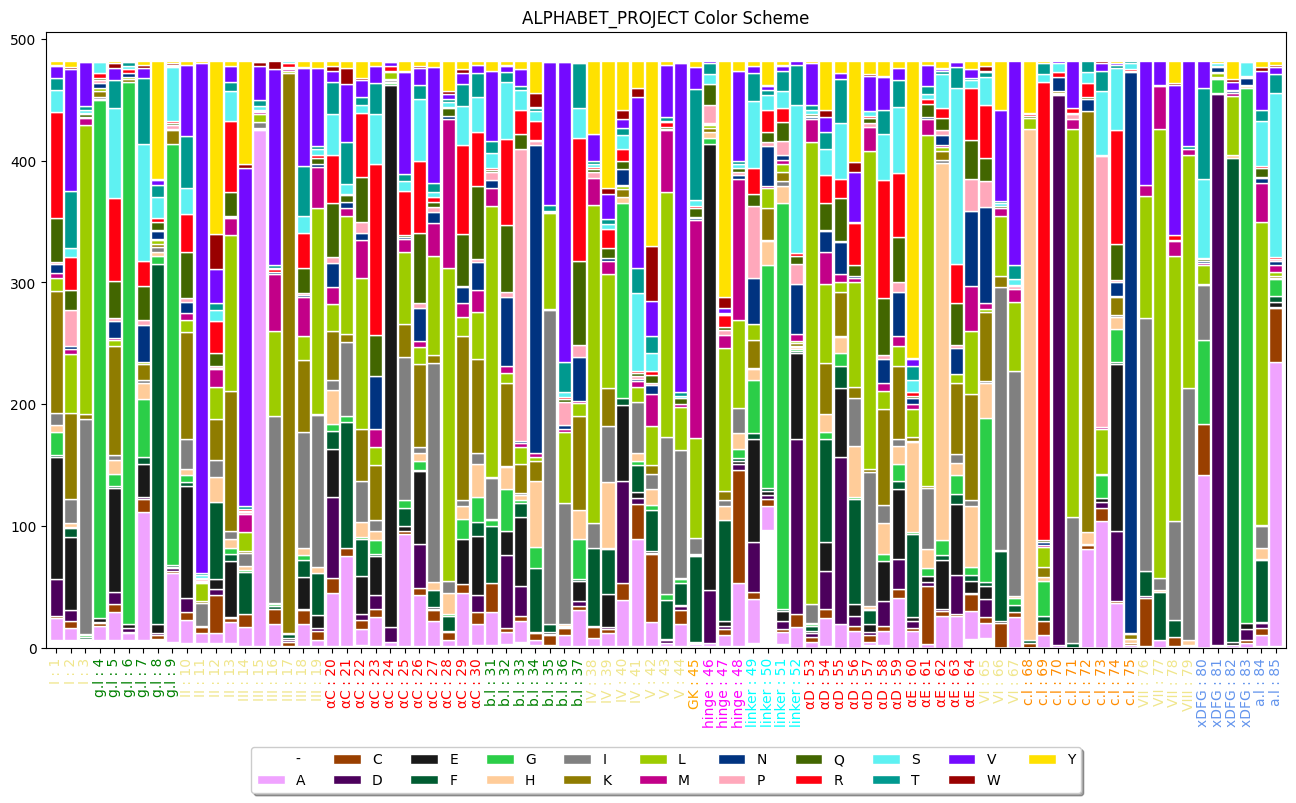

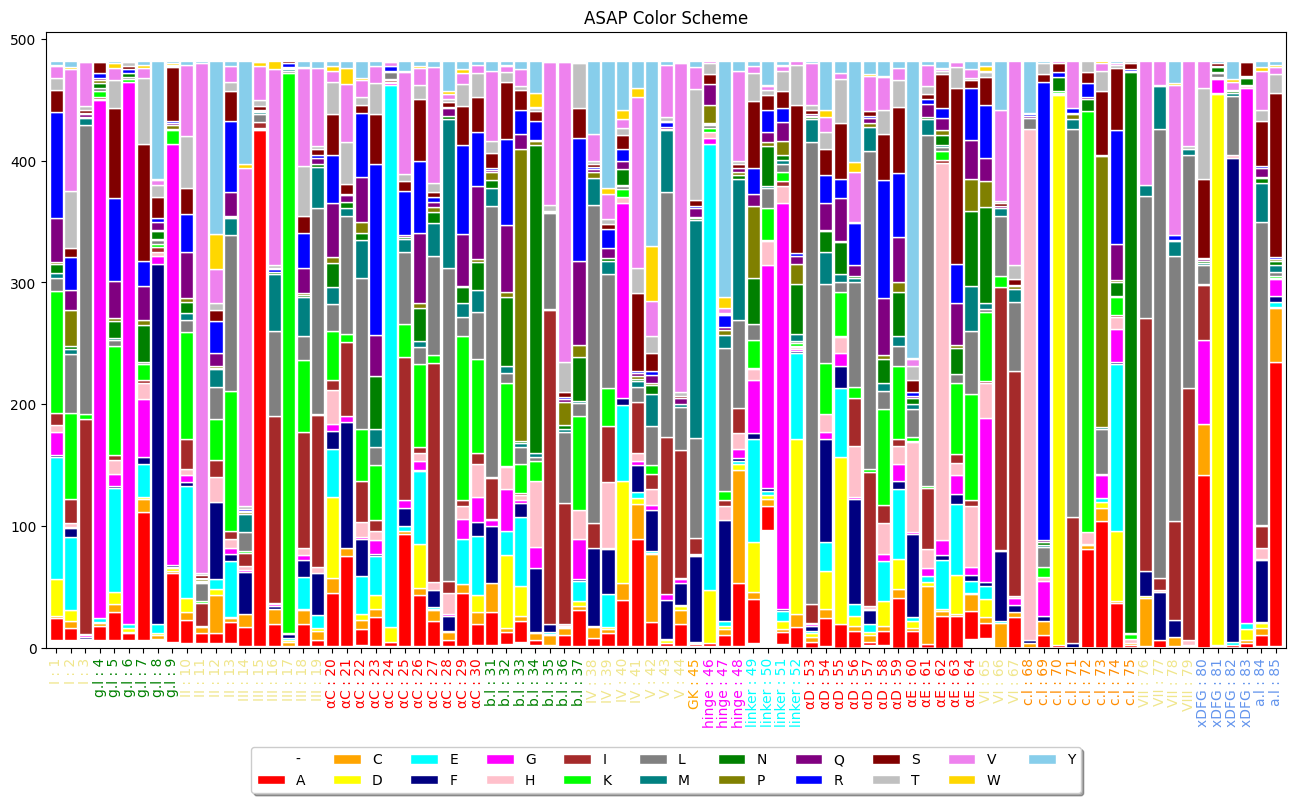

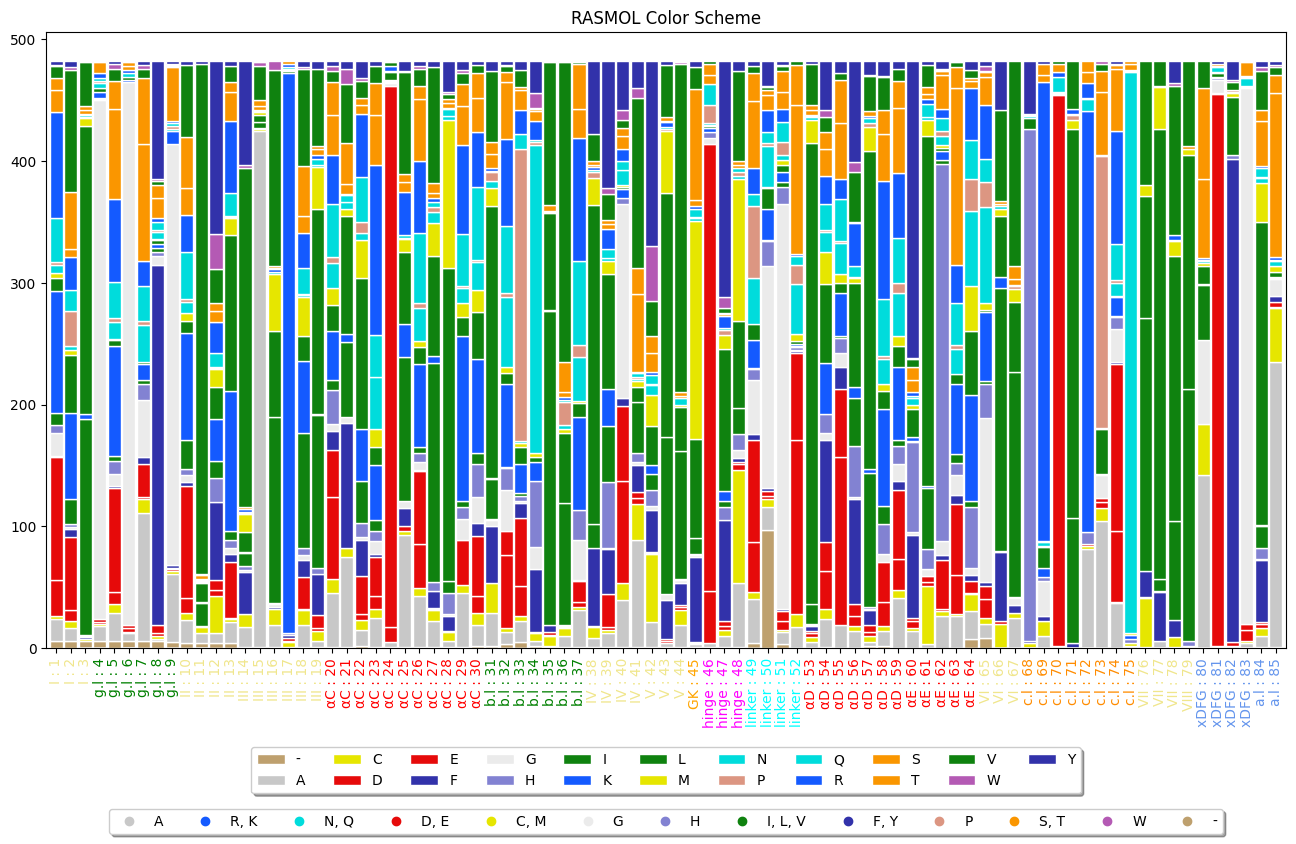

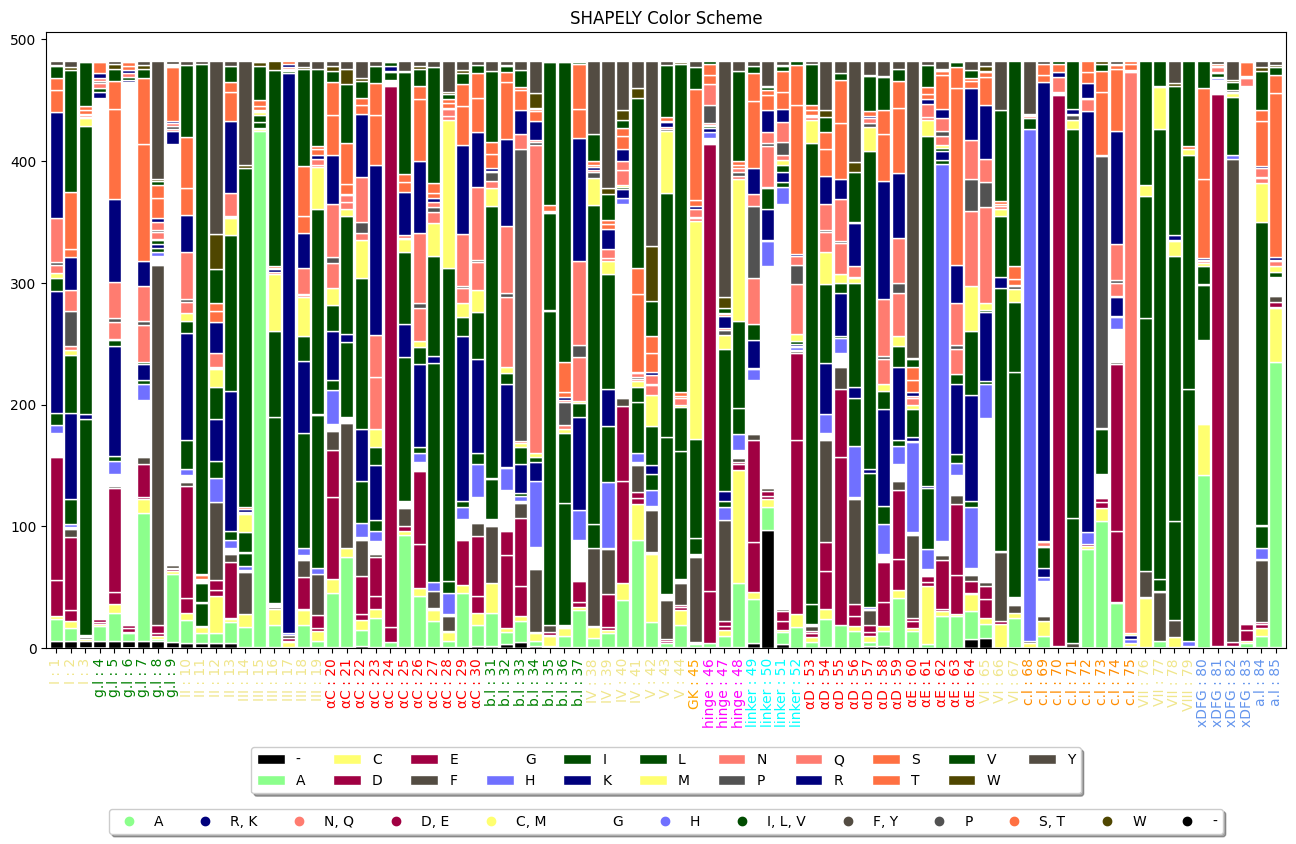

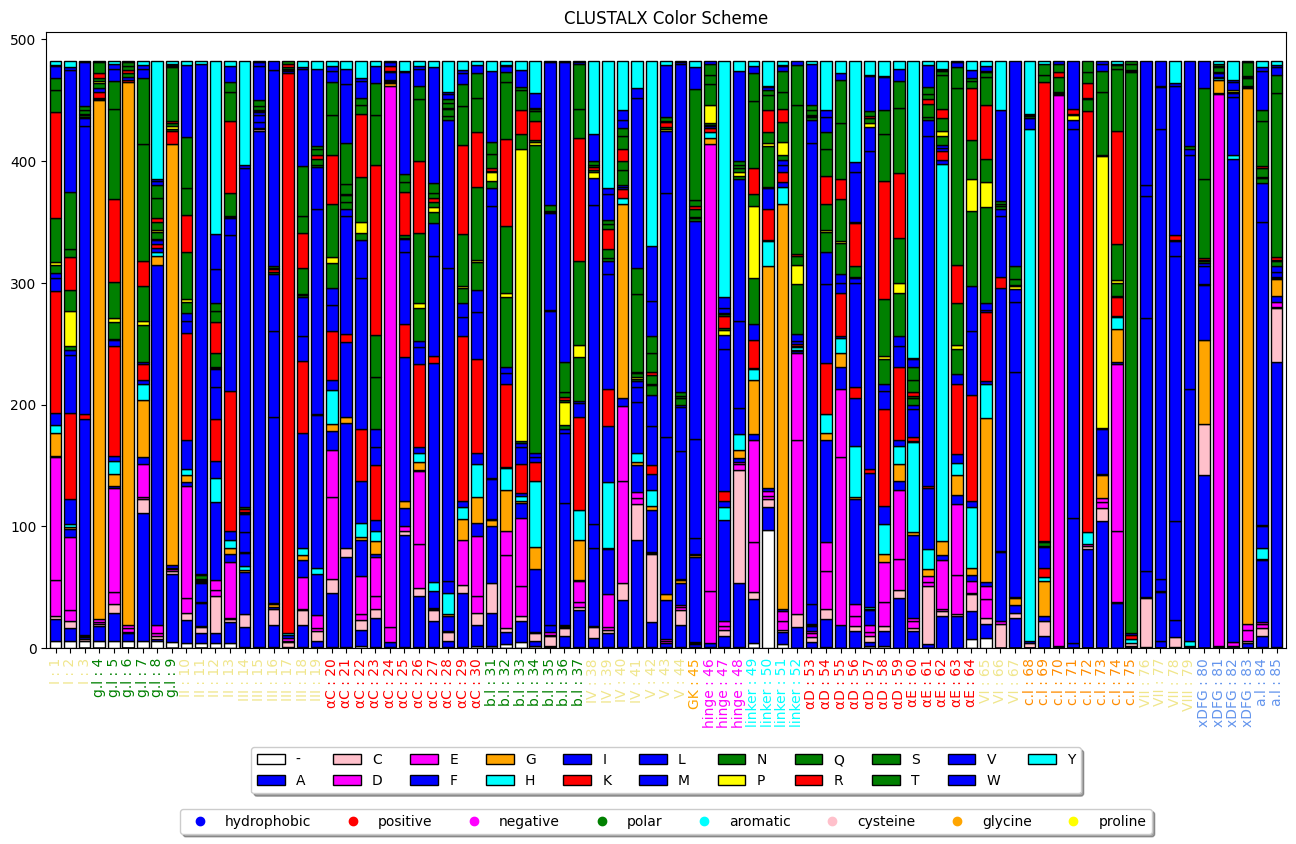

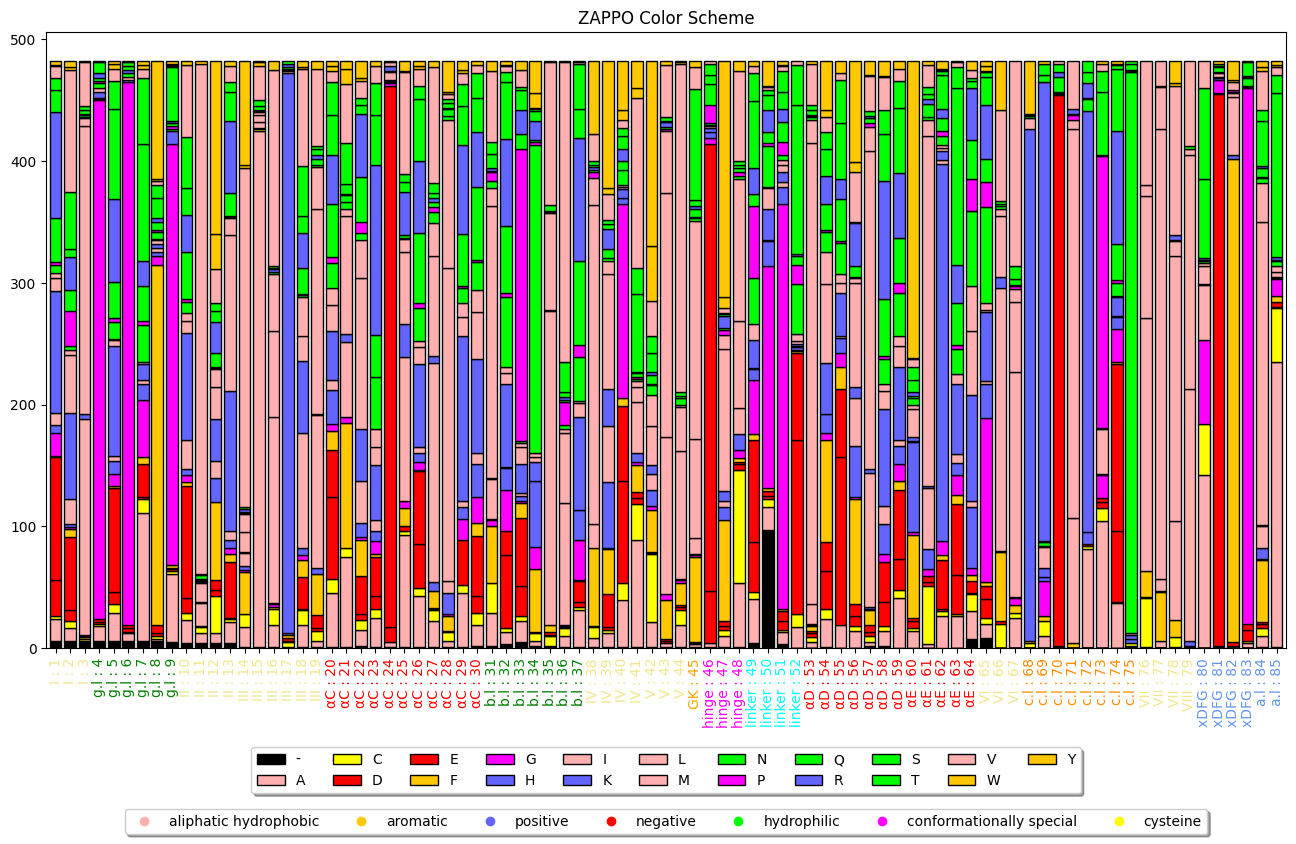

In [15]:
# change x-axis lablel to include KLIFS pocket region
list_cols = [[f"{key} : {i}" for i in range(val["start"], val["end"] + 1)] \
             for key, val in klifs.DICT_POCKET_KLIFS_REGIONS.items()]
list_cols = list(chain.from_iterable(list_cols))
df_pocket_pivot.columns = list_cols

# match x-axis label colors to KLIF pocket region colors
list_axis_col = [[val["color"]] * (val["end"] + 1 - val["start"]) \
                 for _, val in klifs.DICT_POCKET_KLIFS_REGIONS.items()]
list_axis_col = list(chain.from_iterable(list_axis_col))

list_cols = list(colors.DICT_COLORS.keys())
for cols in list_cols:
    print(cols)
    str_col = cols
    dict_col = colors.DICT_COLORS[str_col]["DICT_COLORS"]
    list_fill_col = [colors.map_single_letter_aa_to_color(i, dict_col) \
                     for i in df_pocket_pivot.index.tolist()]
    
    if len(set(list_fill_col)) > 9:
        edgecol = "white"
        colwidth = 0.9
    else:
        edgecol = "black"
        colwidth = 0.8
    
    ax = df_pocket_pivot.T.plot(kind='bar', 
                                stacked=True, 
                                figsize=(16, 8),
                                color=list_fill_col,
                                edgecolor = edgecol, 
                                width = colwidth);
    
    for xtick, color in zip(ax.get_xticklabels(), list_axis_col):
        xtick.set_color(color)
    
    dict_annot = colors.DICT_COLORS[str_col]["DICT_ANNOTATION"]
    if dict_annot is None:
        ax.legend(loc="upper center", 
              bbox_to_anchor=(0.5, -0.15),
              fancybox=True, 
              shadow=True, 
              ncol=11)
    else:
        l1 = ax.legend(loc="upper center", 
                       bbox_to_anchor=(0.5, -0.15),
                       fancybox=True, 
                       shadow=True, 
                       ncol=11)
        handlelist = [plt.plot([], marker="o", ls="", color=color)[0] for _, color in dict_annot.items()]
        l2 = ax.legend(handlelist,
                       list(dict_annot.keys()),
                       loc="upper center", 
                       bbox_to_anchor=(0.5, -0.25),
                       fancybox=True, 
                       shadow=True, 
                       ncol=len(dict_annot))
        ax.add_artist(l1)
    plt.title(f"{cols} Color Scheme")
    plt.savefig(f"KLIFS_pocket_{cols}.pdf", bbox_inches="tight");

# Align KLIFS pocket residues to canonial sequence

In [2]:
from dataclasses import asdict
import json
import re

from missense_kinase_toolkit.databases import kinase_schema

## Load data

In [4]:
df_klifs_narm = df_klifs.loc[~df_klifs["pocket"].isna(), ].reset_index(drop=True)
df_klifs_uniprot_narm = df_klifs_narm.merge(df_uniprot, left_on="uniprot", right_on="uniprot_id", how="left")

# df_klifs.loc[df_klifs["pocket"].isna(), ]
# df_klifs_narm.loc[df_klifs_narm["pocket"].apply(lambda x: "-" in x), ]
# df_klifs_uniprot_narm.iloc[1]

In [ ]:
# list_family = list(chain.from_iterable(df_kinhub["Family"].apply(lambda x: x.split(", ")).tolist()))
# dict_family = {item: list_family.count(item) for item in set(list_family)}
# dict_family = {k: v for k, v in sorted(dict_family.items(), key=lambda item: item[1], reverse=True)}
# [key for key, val in dict_family.items() if val >= 5] # kinase_schema.Family

# list_subfamily = list(chain.from_iterable(df_kinhub["SubFamily"].apply(lambda x: str(x).split(", ")).tolist()))
# dict_subfamily = {item: list_subfamily.count(item) for item in set(list_subfamily)}
# dict_subfamily = {k: v for k, v in sorted(dict_subfamily.items(), key=lambda item: item[1], reverse=True)}
# [key for key, val in dict_subfamily.items() if val >= 5] # kinase_schema.SubFamily NOT IN USE AS N=3
# df_pivot = pd.DataFrame(df_kinhub[["Family", "SubFamily"]].value_counts()).reset_index().pivot(columns="Family", index="SubFamily", values="count")
# df_pivot.loc[df_pivot.index.isin([key for key, val in dict_subfamily.items() if val >= 5]),].dropna(axis=1, how="all")

# "".join(sorted(list(set(chain.from_iterable(df_uniprot["canonical_sequence"].apply(lambda x: list(x)).tolist()))))) # kinase_schema.Kinase.uniprot_seq

# "".join(sorted(list(set(chain.from_iterable(df_klifs_uniprot_narm["pocket"].apply(lambda x: list(x)).tolist()))))) # kinase_schema.Kinase.klifs_pocket

In [3]:
dict_kinase = kinase_schema.create_kinase_models_from_df()

In [4]:
dict_klifs = {i: j for i, j in dict_kinase.items() if \
              (j.KLIFS is not None and j.KLIFS.pocket_seq is not None)}

## Generate KLIFS alignment

In [5]:
list_KLIFSPocket = []
for _, j in dict_klifs.items():
    uniprot_id = j.uniprot_id
    hgnc = j.hgnc_name
    str_uniprot = j.UniProt.canonical_seq
    str_klifs_pocket = j.KLIFS.pocket_seq
    if j.KinCore is not None:
        

    dict_temp2 = klifs.iterate_klifs_alignment(str_uniprot, str_klifs_pocket)

    dict_temp1 = {"uniprotID": uniprot_id,
                  "hgncName": hgnc,
                  "uniprotSeq": str_uniprot,
                  "klifsSeq": str_klifs_pocket}

    dict_out = dict(dict_temp1, **dict_temp2)

    list_KLIFSPocket.append(klifs.KLIFSPocket(**dict_out))

In [ ]:
# print(json.dumps(asdict([i for i in list_KLIFSPocket if i.hgncName == "FGFR4"][0]), 
#                  indent=4, sort_keys=False, ensure_ascii=False))

In [6]:
list_KLIFSPocket[0]

KLIFSPocket(uniprotID='P00519', hgncName='ABL1', uniprotSeq='MLEICLKLVGCKSKKGLSSSSSCYLEEALQRPVASDFEPQGLSEAARWNSKENLLAGPSENDPNLFVALYDFVASGDNTLSITKGEKLRVLGYNHNGEWCEAQTKNGQGWVPSNYITPVNSLEKHSWYHGPVSRNAAEYLLSSGINGSFLVRESESSPGQRSISLRYEGRVYHYRINTASDGKLYVSSESRFNTLAELVHHHSTVADGLITTLHYPAPKRNKPTVYGVSPNYDKWEMERTDITMKHKLGGGQYGEVYEGVWKKYSLTVAVKTLKEDTMEVEEFLKEAAVMKEIKHPNLVQLLGVCTREPPFYIITEFMTYGNLLDYLRECNRQEVNAVVLLYMATQISSAMEYLEKKNFIHRDLAARNCLVGENHLVKVADFGLSRLMTGDTYTAHAGAKFPIKWTAPESLAYNKFSIKSDVWAFGVLLWEIATYGMSPYPGIDLSQVYELLEKDYRMERPEGCPEKVYELMRACWQWNPSDRPSFAEIHQAFETMFQESSISDEVEKELGKQGVRGAVSTLLQAPELPTKTRTSRRAAEHRDTTDVPEMPHSKGQGESDPLDHEPAVSPLLPRKERGPPEGGLNEDERLLPKDKKTNLFSALIKKKKKTAPTPPKRSSSFREMDGQPERRGAGEEEGRDISNGALAFTPLDTADPAKSPKPSNGAGVPNGALRESGGSGFRSPHLWKKSSTLTSSRLATGEEEGGGSSSKRFLRSCSASCVPHGAKDTEWRSVTLPRDLQSTGRQFDSSTFGGHKSEKPALPRKRAGENRSDQVTRGTVTPPPRLVKKNEEAADEVFKDIMESSPGSSPPNLTPKPLRRQVTVAPASGLPHKEEAGKGSALGTPAAAEPVTPTSKAGSGAPGGTSKGPAEESRVRRHKHSSESPGRDKGKLSRLKPAPPPPPAASAGKAGGKPSQSPSQEAAGEAVLGAKTKATSLVD

In [7]:
from missense_kinase_toolkit.databases.aligners import BL2UniProtAligner

In [8]:
dict_klifs = klifs.DICT_POCKET_KLIFS_REGIONS
list_klifs = list(dict_klifs.keys())

In [9]:
idx_bl = [i for i, x in enumerate(list_klifs) if x == "b.l"][0]

In [40]:
list_KLIFSPocket_bl = list_KLIFSPocket.copy()
for idx, pocket in enumerate(list_KLIFSPocket_bl):
    # try:
    start, end, bl_alignments = klifs.return_partial_alignments(
        idx=idx_bl,
        substring_idx_list=pocket.list_substring_idxs,
        substring_actual_list=pocket.list_klifs_substr_actual,
        uniprot_seq=pocket.uniprotSeq,
        align_fn=BL2UniProtAligner(),
    )
    try:
        list_bl = klifs.select_correct_bl_alignment(bl_alignments)
        list_bl = [i + start for i in list_bl]
        list_KLIFSPocket_bl[idx].list_substring_idxs[idx_bl] = list_bl
    except:
        print(pocket.hgncName)
        for i in bl_alignments:
            print(i)
    # except:
    #     print(pocket.hgncName)

BUB1B
target            0 -DFDHF 5
                  0 -||||| 6
query             0 EDFDHF 6

PIK3R4
target            0 RLNS 4
                  0 |||| 4
query             0 RLNS 4



TypeError: 'NoneType' object is not subscriptable

In [42]:
[i for i in list_KLIFSPocket if i.hgncName == "STK40"][0]

KLIFSPocket(uniprotID='Q8N2I9', hgncName='STK40', uniprotSeq='MKRRASDRGAGETSARAKALGSGISGNNAKRAGPFILGPRLGNSPVPSIVQCLARKDGTDDFYQLKILTLEERGDQGIESQEERQGKMLLHTEYSLLSLLHTQDGVVHHHGLFQDRTCEIVEDTESSRMVKKMKKRICLVLDCLCAHDFSDKTADLINLQHYVIKEKRLSERETVVIFYDVVRVVEALHQKNIVHRDLKLGNMVLNKRTHRITITNFCLGKHLVSEGDLLKDQRGSPAYISPDVLSGRPYRGKPSDMWALGVVLFTMLYGQFPFYDSIPQELFRKIKAAEYTIPEDGRVSENTVCLIRKLLVLDPQQRLAAADVLEALSAIIASWQSLSSLSGPLQVVPDIDDQMSNADSSQEAKVTEECSQYEFENYMRQQLLLAEEKSSIHDARSWVPKRQFGSAPPVRRLGHDAQPMTSLDTAILAQRYLRK', klifsSeq='-------------------------------------------------NLQHYVIKEKALHQKNIVHRDLKLGNMVLITNFCLG', list_klifs_region=['I:I', 'g.l:g.l', 'II:II', 'III:III', 'αC:αC', 'b.l:b.l', 'IV:IV', 'V:V', 'GK:GK', 'hinge:hinge', 'linker:linker', 'αD:αD', 'αE:αE', 'VI:VI', 'c.l:c.l', 'VII:VII', 'VIII:xDFG', 'xDFG:xDFG', 'xDFG:a.l'], list_klifs_substr_actual=['---', '------', '----', '------', '-----------', '-------', '----', '---', '-', '---', '-NLQ', 'HYVIKEK', 'ALHQK', 'NIV', 'HRDLKLGN', 'MVL', 'I', 'TNFC',

In [41]:
list_KLIFSPocket_bl = list_KLIFSPocket.copy()
for idx, pocket in enumerate(list_KLIFSPocket_bl):
    try:
        start, end, bl_alignments = klifs.return_partial_alignments(
            idx=idx_bl,
            substring_idx_list=pocket.list_substring_idxs,
            substring_actual_list=pocket.list_klifs_substr_actual,
            uniprot_seq=pocket.uniprotSeq,
            align_fn=BL2UniProtAligner(),
        )
        try:
            list_bl = klifs.select_correct_bl_alignment(bl_alignments)
            list_bl = [i + start for i in list_bl]
            list_KLIFSPocket_bl[idx].list_substring_idxs[idx_bl] = list_bl
        except:
            print(pocket.hgncName)
            for i in bl_alignments:
                print(i)
    except:
        print(pocket.hgncName)

BUB1B
target            0 -DFDHF 5
                  0 -||||| 6
query             0 EDFDHF 6

PIK3R4
target            0 RLNS 4
                  0 |||| 4
query             0 RLNS 4

STK40


In [36]:
for i in bl_alignments:
    print(i)

target            0 -DFDHF 5
                  0 -||||| 6
query             0 EDFDHF 6



In [35]:
print(bl_alignments)

In [11]:
start

292

In [12]:
end

300

In [19]:
list_bl = klifs.select_correct_bl_alignment(bl_alignments)
list_bl = [i + start for i in list_bl]

In [20]:
"".join([list_KLIFSPocket[0].uniprotSeq[i] for i in list_bl])

'IKPNLVQ'

In [26]:
list_KLIFSPocket[0].list_klifs_substr_actual[idx_bl]

'IKPNLVQ'

In [25]:
dict_klifs["b.l"][start]

{'start': 31, 'end': 37, 'contiguous': True, 'color': 'green'}

In [27]:
list_KLIFSPocket[0].klifsSeq

'HKLGGGQYGEVYEVAVKTLEFLKEAAVMKEIKPNLVQLLGVYIITEFMTYGNLLDYLREYLEKKNFIHRDLAARNCLVVADFGLS'

In [33]:
idx_start = list_KLIFSPocket[0].list_substring_idxs[0][0]
list_KLIFSPocket[0].uniprotSeq[idx_start:idx_start + len(list_KLIFSPocket[0].list_klifs_substr_actual[0])]

'HKL'

In [23]:
dict_klifs = klifs.DICT_POCKET_KLIFS_REGIONS
list_klifs = list(dict_klifs.keys())

In [24]:
idx_bl = [i for i, x in enumerate(list_klifs) if x == "b.l"][0]

In [25]:
idx_bl

5

In [26]:
list_KLIFSPocket[0].list_klifs_substr_actual[idx_bl]

'IKPNLVQ'

In [ ]:
list_KLIFSPocket[0].list_klifs_substr_actual[idx_bl]

In [29]:
list_KLIFSPocket[0].list_klifs_region[idx_bl]

'b.l:b.l'

In [30]:
set([i.list_klifs_region[idx_bl] for i in list_KLIFSPocket])

{'b.l:b.l'}

In [ ]:
[i.list_klifs_region[idx_bl] for i in list_KLIFSPocket if i.list_klifs_region[idx_bl]]

In [117]:
type(aligner)

Bio.Align.PairwiseAligner

In [32]:
aligner = BL2UniProtAligner()

In [98]:
alignments = aligner.align("NSLHIRT", "NSLINKCLRKDAESRRRELHIRT")

In [38]:
for i in temp:
    print(i)

target            0 NS----------------LHIRT  7
                  0 ||----------------||||| 23
query             0 NSLINKCLRKDAESRRRELHIRT 23

target            0 NSL----------------HIRT  7
                  0 |||----------------|||| 23
query             0 NSLINKCLRKDAESRRRELHIRT 23



In [101]:
list_alignments = [re.findall(r"[A-Z]+", alignment[0, :]) for alignment in alignments]

In [102]:
list_idx = [idx for idx, i in enumerate(list_alignments) if len(i) == 2 and len(i[0]) == 2]

In [103]:
list_idx

[0]

In [104]:
target = alignments[list_idx[0]].indices[0]
query = alignments[list_idx[0]].indices[1]

target[target >= 0] = 1
target = np.where(target == -1, np.nan, target)

output = target * query
output = output[~np.isnan(output)]

In [116]:
[int(i) for i in output.tolist()]

[0, 1, 18, 19, 20, 21, 22]

In [44]:
temp[0].coordinates[:1]

array([[0, 2, 2, 7]])

In [118]:
list_KLIFSPocket[0].list_substring_idxs

[[245],
 [248],
 [254],
 [267],
 [281],
 [],
 [300],
 [311],
 [314],
 [315],
 [318],
 [322],
 [352],
 [357],
 [360],
 [368],
 [378],
 [379],
 [383]]

## Partial match alignment

In [94]:
def find_start_or_end_index_recursively(
    idx_in: int, 
    list_idx: list[int],
    list_substr: list[str],
    idx_kd = None,
    seq_uniprot = None,
    bool_start = True
) -> int:
    """Find the start or end index of the flanking regions.

    Parameters
    ----------
    idx_in : int
        [TO COME]  
    list_idx : list[int]
        [TO COME]
    list_substr: list[str]
        [TO COME]
    idx_kd
    """
    if bool_start:
        # return sequence start if idx = 0
        if idx_in == 0:
            if idx_kd is None:
                return 0
            else:
                return idx_kd
        try:
            idx_out = list_idx[idx_in-1][0] + \
            len(klifs.remove_gaps_from_klifs(list_substr[idx_in-1]))
        except IndexError or TypeError:
            idx_out = find_start_or_end_recursively(idx_in-1,
                                                    list_idx,
                                                    list_substr,
                                                    bool_start = True)
    else:
        # return sequence end if last region
        if idx_in == len(klifs.DICT_POCKET_KLIFS_REGIONS) - 1:
            try:
                idx_out = int(list_idx[idx_in][0])
            except:
                idx_out = len(seq_uniprot)-1
        try:
            idx_out = int(list_idx[idx_in+1][0])
        except IndexError or TypeError:
            idx_out = find_start_or_end_recursively(idx_in+1,
                                                    list_idx,
                                                    list_substr,
                                                    bool_start = False)

    return idx_out

In [ ]:
# print(json.dumps(asdict([i for i in list_KLIFSPocket if i.hgncName == "ADCK3"][0]), 
#                  indent=4, sort_keys=False, ensure_ascii=False))

In [92]:
from Bio import Align
from Bio.Align import substitution_matrices

aligner = Align.PairwiseAligner()
aligner.mode = "global"
aligner.substitution_matrix = substitution_matrices.load("BLOSUM62")
aligner.open_gap_score = -5
aligner.extend_gap_score = -1

In [34]:
dict_test["list_substring_idxs"]

[[492],
 [495],
 [501],
 [516],
 [532],
 [],
 [550],
 [567],
 [570],
 [571],
 [574],
 [578],
 [629],
 [634],
 [637],
 [645],
 [655],
 [656],
 [660]]

In [35]:
dict_test["list_klifs_substr_actual"]

['RIQ',
 'KSSNFG',
 'YITS',
 'PYCLRR',
 'CM-VLVDMWKK',
 'IQSNIVT',
 'LREV',
 'AYD',
 'F',
 'HAG',
 'GETM',
 'MSRHFND',
 'TIHTA',
 'GLA',
 'CRVMDPTK',
 'ILI',
 'V',
 'NCVG',
 'VF']

In [95]:
dict_multi = {}
dict_mono = {}

for test in list_KLIFSPocket:
    # dict_test = asdict(test)
    list_substring_idxs = test.list_substring_idxs
    list_idx_no_match = [idx for idx, i in enumerate(list_substring_idxs)\
                              if not i and i is not None]

    for idx in list_idx_no_match:
        start_idx = find_start_or_end_recursively(idx,
                                                  test.list_substring_idxs,
                                                  test.list_klifs_substr_actual,
                                                  bool_start=True)
        end_idx = find_start_or_end_recursively(idx,
                                                test.list_substring_idxs,
                                                test.list_klifs_substr_actual,
                                                bool_start=False)
    
        alignments = aligner.align(klifs.remove_gaps_from_klifs(test.list_klifs_substr_actual[idx]), 
                                   test.uniprotSeq[start_idx:end_idx])
        if len(list(alignments)) > 1:
            dict_multi[f"{test.hgncName},{test.list_klifs_region[idx]}"] = list(alignments)
        else:
            dict_mono[f"{test.hgncName},{test.list_klifs_region[idx]}"] = list(alignments)

In [119]:
list_bl = [i for i in list(dict_multi.keys())if "b.l:b.l" in i]
dict_bl = {key: val for key, val in dict_multi.items() if key in list_bl}

In [ ]:
for i, j in dict_bl.items():
    

In [96]:
list_bl = [i for i in list(dict_multi.keys())if "b.l:b.l" in i]
dict_bl = {key: val for key, val in dict_multi.items() if key in list_bl}

for reg in list_bl:
    print(reg)
    for alignment in dict_multi[reg]:
        print("Score = %.1f:" % alignment.score)
        print(alignment)
    print("\end\n")

# keep only if 2 regions and the first is 2 AA long
dict_multi_bl = {}
for key, val in dict_bl.items():
    list_temp = []
    for idx, alignment in enumerate(val):
        list_dash = re.findall(r"[A-Z]+", alignment[0, :])
        if len(list_dash) == 2 and len(list_dash[0]) == 2:
            dict_multi_bl[key] = [val[idx]]

ATR,b.l:b.l
Score = 16.0:
target            0 NS----------------LHIRT  7
                  0 ||----------------||||| 23
query             0 NSLINKCLRKDAESRRRELHIRT 23

Score = 16.0:
target            0 NSL----------------HIRT  7
                  0 |||----------------|||| 23
query             0 NSLINKCLRKDAESRRRELHIRT 23

\end

CSNK1G3,b.l:b.l
Score = 32.0:
target            0 L--GDGIPQ 7
                  0 |--|||||| 9
query             0 LGSGDGIPQ 9

Score = 32.0:
target            0 LG--DGIPQ 7
                  0 ||--||||| 9
query             0 LGSGDGIPQ 9

\end

CLK3,b.l:b.l
Score = 25.0:
target            0 I-------KFLCVL  7
                  0 |-------|||||| 14
query             0 IKEKDKENKFLCVL 14

Score = 25.0:
target            0 IK-------FLCVL  7
                  0 ||-------||||| 14
query             0 IKEKDKENKFLCVL 14

\end

DAPK2,b.l:b.l
Score = 30.0:
target            0 VL-HNVIT 7
                  0 ||-||||| 8
query             0 VLHHNVIT 8

Score = 30.0:
target       

In [11]:
list_not_bl = [i for i in list(dict_multi.keys())if "b.l:b.l" not in i]
dict_not_bl = {key: val for key, val in dict_multi.items() if key in list_not_bl}
list_region = []

for key, val in dict_not_bl.items():
    print(key)
    for alignment in val:
        print("Score = %.1f:" % alignment.score)
        print(alignment)
    list_region.append(key.split(",")[1])
    print("\end\n")
dict_region = {item: list_region.count(item) for item in set(list_region)}
print(f"Regions with multiple alignments:\n{dict_region}")

DMPK1,II:III
Score = 4.0:
target            0 EVA---------V  4
                  0 |||---------| 13
query             0 EVAVVKMKQTGQV 13

Score = 4.0:
target            0 EVAV---------  4
                  0 ||||--------- 13
query             0 EVAVVKMKQTGQV 13

\end

PDGFRa,b.l:IV
Score = -6.0:
target            0 ---------LLGA-------  4
                  0 ---------||||------- 20
query             0 LGPHLNIVNLLGACTKSGPI 20

Score = -6.0:
target            0 L---------LGA-------  4
                  0 |---------|||------- 20
query             0 LGPHLNIVNLLGACTKSGPI 20

\end

ADCK1,linker:linker
Score = -63.0:
target            0 ------------------------------------------------------------
                  0 ------------------------------------------------------------
query             0 LMEVLVLAVKQLFPEFEFMWLVDEAKKNLPLELDFLNEGRNAEKVSQMLRHFDFLKVPRI

target            0 -------------F---GQV  4
                 60 -------------|---||| 80
query            60 HWDLSTERVLLMEFVDGGQV 80

Score

In [122]:
klifs.return_idx_of_substring_in_superstring(dict_kinase["ADCK3"].KLIFS.pocket_seq, "NFM")

[64]

In [131]:
idx_replace = klifs.return_idx_of_substring_in_superstring(dict_kinase["ADCK3"].KLIFS.pocket_seq, "NFM")[0]
str_temp = dict_kinase["ADCK3"].KLIFS.pocket_seq
 # = "H"

In [136]:
len(str_temp[0:idx_replace] + "H" + str_temp[idx_replace + 1:])

85

In [127]:
str_temp[klifs.return_idx_of_substring_in_superstring(dict_kinase["ADCK3"].KLIFS.pocket_seq, "NFM")[0]]

'N'

In [30]:
print("***KINASES WITH MISMATCHED RESIDUES***\n")
i = 0
for key, val in dict_mono.items():
    for entry in val:
        str_align = str(entry).split("\n")[1].split(" ")[-2]
        if "." in str_align:
            print(key)
            print(entry)
            print("")
            i += 1
print(f"{i} kinases with mismatched residues")
print("\end\n")

print("***KINASES WITH MULTIPLE GAPS***\n")
i = 0
for key, val in dict_mono.items():
    for entry in val:
        list_dash = re.findall(r"\W+", entry[0, :])
        if len(list_dash) > 1:
            print(key)
            print(entry)
            print("")
            i += 1
print(f"{i} kinases with multiple gaps")
print("\end\n")

print("***KINASES WITH SINGLE GAPS >5 AMINO ACIDS LONG***\n")
i = 0
gap = 5
for key, val in dict_mono.items():
    for entry in val:
        list_dash = re.findall(r"\W+", entry[0, :])
        str_align = str(entry).split("\n")[1].split(" ")[-2]
        if len(list_dash) == 1 and str_align.count("-") > gap:
            print(key)
            print(entry)
            print("")
            i += 1
print(f"{i} kinases with single gaps >{gap} AAs")
print("\end\n")

# print("***ALL SINGLY ALIGNED KINASE KLIFS REGIONS***\n")
# for key, val in dict_mono.items():
#     print(key)
#     for entry in val:
#         print("Score = %.1f:" % entry.score)
#         print(entry)
# print("\end\n")

***KINASES WITH MISMATCHED RESIDUES***

ADCK3,VI:VI
target            0 NFM 3
                  0 .|| 3
query             0 HFM 3


1 kinases with mismatched residues
\end

***KINASES WITH MULTIPLE GAPS***

AMPKa1,b.l:b.l
target            0 FR-PHIIK-----------  7
                  0 ||-|||||----------- 19
query             0 FRHPHIIKLYQVISTPSDI 19


AMPKa1,b.l:IV
target            0 --------LYQV-------  4
                  0 --------||||------- 19
query             0 FRHPHIIKLYQVISTPSDI 19


FGFR4,b.l:b.l
target            0 IG--KNIIN-----------  7
                  0 ||--|||||----------- 20
query             0 IGRHKNIINLLGVCTQEGPL 20


FGFR4,b.l:IV
target            0 ---------LLGV-------  4
                  0 ---------||||------- 20
query             0 IGRHKNIINLLGVCTQEGPL 20


MSK1,b.l:b.l
target            0 IR--PFLVT-----------  7
                  0 ||--|||||----------- 20
query             0 IRQSPFLVTLHYAFQTETKL 20


MSK1,b.l:IV
target            0 ---------LHYA-------  4
    

## Diagnostics

In [144]:
# regions that are technically missing (all "-")
for klifspocket in list_KLIFSPocket:
    list_temp = [idx for idx, i in enumerate(klifspocket.list_substring_idxs) if i is None]
    if len(list_temp) > 0:
        print(f"{klifspocket.hgncName}")
        for idx in list_temp:
            print(f"{klifspocket.list_klifs_region[idx]}: {klifspocket.list_klifs_substr_actual[idx]}")
        print("")

SCYL1
I:I: ---

SCYL3
I:I: ---
g.l:g.l: ------

SgK495
I:I: ---
g.l:g.l: ------
II:II: ----
III:III: ------
αC:αC: -----------
b.l:b.l: -------
IV:IV: ----
V:V: ---
GK:GK: -
hinge:hinge: ---

RSKL1
I:I: ---
g.l:g.l: ------
II:II: ----

Slob
a.l:a.l: --

TBCK
I:I: ---
g.l:g.l: ------
II:II: ----

SgK307
I:I: ---
g.l:g.l: ------
II:II: ----



In [145]:
# regions where no exact match is found for sequence (b.l only)
for klifspocket in list_KLIFSPocket:
    list_temp = [idx for idx, i in enumerate(klifspocket.list_substring_idxs) if not i]
    for idx in list_temp:
        try:
            if (klifspocket.list_klifs_region[idx].split(":")[0] == \
            klifspocket.list_klifs_region[idx].split(":")[1] and \
            klifspocket.list_klifs_region[idx].split(":")[0] == "b.l"):
                if all(i != "-" for i in list(klifspocket.list_klifs_substr_actual[idx])):
                    print(f"{klifspocket.hgncName}")
                    print(f"{klifspocket.list_klifs_region[idx]}: {klifspocket.list_klifs_substr_actual[idx]}")
                    print("")
        except IndexError:
            continue

ABL1
b.l:b.l: IKPNLVQ

ACK
b.l:b.l: LDRNLIR

ACTR2
b.l:b.l: PGENILQ

ACTR2B
b.l:b.l: PGENLLQ

ADCK4
b.l:b.l: FRFRVPA

Trb1
b.l:b.l: PSSNITG

BRSK2
b.l:b.l: IEPHVLK

Wnk2
b.l:b.l: LQPNIVR

AKT1
b.l:b.l: SRPFLTA

AKT2
b.l:b.l: TRPFLTA

AKT3
b.l:b.l: TRPFLTS

CaMK1g
b.l:b.l: IKENIVT

ALK
b.l:b.l: FNQNIVR

ALK1
b.l:b.l: VLDNILG

ALK2
b.l:b.l: VMENILG

BMPR1A
b.l:b.l: VLENILG

ALK4
b.l:b.l: VMENILG

TGFbR1
b.l:b.l: VMENILG

BMPR1B
b.l:b.l: VLENILG

AMPKa1
b.l:b.l: FRPHIIK

AMPKa2
b.l:b.l: FRPHIIK

ANPa
b.l:b.l: VQEHLTR

ANPb
b.l:b.l: VQNHLTR

ARAF
b.l:b.l: TRVNILL

ABL2
b.l:b.l: IKPNLVQ

ATM
b.l:b.l: FQLTICT

ATR
b.l:b.l: NSLHIRT

AurC
b.l:b.l: LQPNILR

AXL
b.l:b.l: FDPNVMR

Map4k2
b.l:b.l: CRPNVVA

BLK
b.l:b.l: LQERLVR

BRAF
b.l:b.l: TRVNILL

BRK
b.l:b.l: LRKHILA

BTK
b.l:b.l: LSEKLVQ

CDK7
b.l:b.l: LSPNIIG

CaMK1a
b.l:b.l: IKPNIVA

CaMK2a
b.l:b.l: LKPNIVR

CaMK2b
b.l:b.l: LKSNIVR

CaMK2g
b.l:b.l: LKPNIVR

CaMK4
b.l:b.l: LSPNIIK

VACAMKL
b.l:b.l: VKPNILQ

DCLK1
b.l:b.l: VKPNIVL

CASK
b.l:b

In [146]:
# regions where no exact match is found for sequence (not b.l only)
for klifspocket in list_KLIFSPocket:
    list_temp = [idx for idx, i in enumerate(klifspocket.list_substring_idxs) if not i]
    for idx in list_temp:
        try:
            if (klifspocket.list_klifs_region[idx].split(":")[0] == \
            klifspocket.list_klifs_region[idx].split(":")[1] and \
            klifspocket.list_klifs_region[idx].split(":")[0] != "b.l"):
                if all(i != "-" for i in list(klifspocket.list_klifs_substr_actual[idx])):
                    print(f"{klifspocket.hgncName}")
                    print(f"{klifspocket.list_klifs_region[idx]}: {klifspocket.list_klifs_substr_actual[idx]}")
                    print("")
        except IndexError:
            continue

ADCK4
linker:linker: LGVP

ATM
linker:linker: TTVP

FRAP
linker:linker: PCDT

PIM3
linker:linker: EAQD

PIM1
linker:linker: EVQD

PIM2
linker:linker: LAQD

TRRAP
linker:linker: PVEI

ADCK1
linker:linker: FGQV

RIOK3
linker:linker: GAPK

ADCK3
VI:VI: NFM

RIOK1
linker:linker: GAPL

SMG1
linker:linker: DATP

LRRK2
I:I: ADH

CaMKK1
I:I: DAY

CaMKK1
g.l:g.l: LQGAYG

ADCK2
linker:linker: YVSS

ADCK5
linker:linker: FCKV



In [147]:
# regions that cannot be found after concatenation
set_regions = set()
for klifspocket in list_KLIFSPocket:
    list_temp = [idx for idx, i in enumerate(klifspocket.list_substring_idxs) if not i]
    for idx in list_temp:
        try:
            if klifspocket.list_klifs_region[idx].split(":")[0] != \
            klifspocket.list_klifs_region[idx].split(":")[1]:
                print(f"{klifspocket.hgncName}")
                print(f"{klifspocket.list_klifs_region[idx]}: {klifspocket.list_klifs_substr_match[idx]}")
                print("")
                set_regions.add(klifspocket.list_klifs_region[idx])
        except IndexError:
            continue

AMPKa1
b.l:IV: FRPHIIKLYQV

DMPK1
II:III: EVAVYAMKIM

FGFR4
b.l:IV: IGKNIINLLGV

PIM3
hinge:linker: ERPEAQD

KIT
II:III: KVVEVAVKML

MSK1
b.l:IV: IRPFLVTLHYA

PDGFRa
b.l:IV: LGLNIVNLLGA

PIM1
hinge:linker: ERPEVQD

TTN
b.l:IV: ARRNILHLHES

TRRAP
hinge:linker: EDNPVEI

ADCK1
hinge:linker: LMEFGQV

CaMKK2
II:III: VVKLYAMKVL

CaMKK2
b.l:IV: LDPNVVKLVEV

TBK1
b.l:IV: LNKNIVKLFAI

SMG1
II:III: LLFLYLFKGL

CaMKK1
V:GK: LYLF



# NOT IN USE

In [ ]:
list_keys = list(klifs.DICT_POCKET_KLIFS_REGIONS.keys())
dict_klifs_idx = {i:dict(zip(list_keys, [None for i in range(len(list_keys))])) for i in df_klifs_uniprot_narm["uniprot"]}
dict_klifs_len = copy.deepcopy(dict_klifs_idx)

list_err_narm = [] # regions that are technically missing (all "-")
list_err_concat = [] # regions that cannot be found after concatenation
list_err_match = [] # regions where no exact match is found for sequence

for idx, klifs_region in enumerate(list_keys):
    for _, row in df_klifs_uniprot_narm.iterrows():
        uniprot_id = row["uniprot"]
        hgnc = row["name"]
        str_uniprot = row["canonical_sequence"]
        str_klifs_pocket = row["pocket"]

        #TODO - add comment
        str_klifs, str_klifs_narm, list_klifs_idx = klifs.align_klifs_pocket_to_uniprot_seq(
            klifs_region_start=klifs_region,
            klifs_region_end=klifs_region,
            string_uniprot=str_uniprot,
            string_klifs=str_klifs_pocket)
        if list_klifs_idx is None:
            dict_klifs_len[uniprot_id][klifs_region], dict_klifs_idx[uniprot_id][klifs_region] = None, None
            list_err_narm.append(f"{hgnc} {klifs_region} ({str_klifs})")
        # if more than one location matches, concatenate regions
        if len(list_klifs_idx) > 1:
            # concatenate with subsequent region
            if idx + 1 < len(list_keys):
                end = dict_klifs_regions[list_keys[idx + 1]]["end"]
                str_keys = f"{key}:{list_keys[idx + 1]}"
            # concatenate with preceding region
            else:
                start = dict_klifs_regions[list_keys[idx - 1]]["start"]
                str_keys = f"{list_keys[idx - 1]}:{key}"
            test_sub = row["pocket"][start:end]
            test_sub_narm = "".join([i for i in test_sub if i != "-"])
            list_start = [i for i in range(len(test_str)) if test_str.startswith(test_sub_narm, i)]
            if len(list_start) != 1:
                list_err_concat.append(f"{row['name']} {str_keys} {len(list_start)} ({test_sub})")
                dict_klifs_idx[row["uniprot"]][key] = np.nan
            else:
                dict_klifs_idx[row["uniprot"]][key] = list_start[0]
        else:
            try:
                dict_klifs_idx[row["uniprot"]][key] = list_start[0]
            except:
                dict_klifs_idx[row["uniprot"]][key] = np.nan
                # b.l is not contiguous - need to do an alternative process
                if key != "b.l":
                    list_err_match.append(f"{row['name']} {key} {len(list_start)} ({test_sub})")

In [211]:
list_err_concat

['SCYL1 I:g.l 20 (--------W)',
 'SCYL3 I:g.l 742 (---------)',
 'SgK495 I:g.l 435 (---------)',
 'RSKL1 I:g.l 1066 (---------)',
 'TBCK I:g.l 893 (---------)',
 'SgK307 I:g.l 1497 (---------)',
 'SgK495 g.l:II 435 (----------)',
 'RSKL1 g.l:II 1066 (----------)',
 'TBCK g.l:II 893 (----------)',
 'SgK307 g.l:II 1497 (----------)',
 'DMPK1 II:III 0 (EVAVYAMKIM)',
 'KIT II:III 0 (KVVEVAVKML)',
 'CaMKK2 II:III 0 (VVKLYAMKVL)',
 'SgK495 II:III 435 (----------)',
 'SMG1 II:III 0 (LLFLYLFKGL)',
 'SgK495 III:αC 435 (-----------------)',
 'SgK495 αC:b.l 435 (------------------)',
 'SgK495 b.l:IV 435 (-----------)',
 'AMPKa1 IV:V 0 (LYQVFMV)',
 'FGFR4 IV:V 0 (LLGVYVI)',
 'MSK1 IV:V 0 (LHYAHLI)',
 'PDGFRa IV:V 0 (LLGAYII)',
 'TTN IV:V 0 (LHESVMI)',
 'CaMKK2 IV:V 0 (LVEVYMV)',
 'SgK495 IV:V 435 (-------)',
 'TBK1 IV:V 0 (LFAIVLI)',
 'IGF1R V:GK 2 (LVIM)',
 'SgK495 V:GK 435 (----)',
 'HH498 V:GK 2 (AIVT)',
 'MPSK1 V:GK 2 (WLLL)',
 'CaMKK1 V:GK 0 (LYLF)',
 'SgK307 V:GK 2 (RLVY)',
 'JAK2 GK:hinge 2 

In [204]:
list_err_narm

['SCYL1 I 1 (---)',
 'SCYL3 I 1 (---)',
 'SgK495 I 1 (---)',
 'RSKL1 I 1 (---)',
 'TBCK I 1 (---)',
 'SgK307 I 1 (---)',
 'SCYL3 g.l 1 (------)',
 'SgK495 g.l 1 (------)',
 'RSKL1 g.l 1 (------)',
 'TBCK g.l 1 (------)',
 'SgK307 g.l 1 (------)',
 'SgK495 II 1 (----)',
 'RSKL1 II 1 (----)',
 'TBCK II 1 (----)',
 'SgK307 II 1 (----)',
 'SgK495 III 1 (------)',
 'SgK495 αC 1 (-----------)',
 'SgK495 b.l 0 (-------)',
 'SgK495 IV 1 (----)',
 'SgK495 V 1 (---)',
 'SgK495 GK 1 (-)',
 'SgK495 hinge 1 (---)',
 'Slob a.l 4 (--)']

In [205]:
list_err_match

['LRRK2 I 0 (ADH)',
 'CaMKK1 I 0 (DAY)',
 'CaMKK1 g.l 0 (LQGAYG)',
 'ADCK4 linker 0 (LGVP)',
 'ATM linker 0 (TTVP)',
 'FRAP linker 0 (PCDT)',
 'PIM3 linker 0 (EAQD)',
 'PIM1 linker 0 (EVQD)',
 'PIM2 linker 0 (LAQD)',
 'TRRAP linker 0 (PVEI)',
 'ADCK1 linker 0 (FGQV)',
 'RIOK3 linker 0 (GAPK)',
 'RIOK1 linker 0 (GAPL)',
 'SMG1 linker 0 (DATP)',
 'ADCK2 linker 0 (YVSS)',
 'ADCK5 linker 0 (FCKV)',
 'ADCK3 VI 0 (NFM)']

In [213]:
pd.DataFrame(dict_klifs_idx)

,P00519,Q07912,P27037,Q13705,Q96D53,Q96RU8,Q8IWQ3,Q9Y3S1,P31749,P31751,...,Q9NSY1,Q9BXA7,Q86YV6,Q7Z695,O43293,P0C1S8,Q05823,Q9BVS4,Q3MIX3,Q58A45
I,245.0,129.0,195.0,193.0,212.0,94.0,22.0,198.0,153.0,155.0,...,54.0,15.0,109.0,284.0,16.0,215.0,368.0,98.0,203.0,492.0
g.l,248.0,132.0,198.0,196.0,215.0,97.0,25.0,201.0,156.0,158.0,...,57.0,18.0,112.0,287.0,19.0,218.0,371.0,101.0,206.0,495.0
II,254.0,138.0,204.0,202.0,221.0,103.0,31.0,207.0,162.0,164.0,...,63.0,24.0,118.0,293.0,25.0,224.0,377.0,107.0,212.0,501.0
III,267.0,154.0,215.0,213.0,233.0,116.0,44.0,220.0,175.0,177.0,...,75.0,37.0,131.0,307.0,38.0,237.0,388.0,119.0,224.0,516.0
αC,281.0,172.0,227.0,225.0,285.0,126.0,61.0,237.0,193.0,195.0,...,90.0,55.0,146.0,361.0,59.0,254.0,399.0,156.0,276.0,532.0
b.l,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
IV,300.0,191.0,248.0,246.0,311.0,145.0,80.0,256.0,212.0,214.0,...,110.0,74.0,165.0,387.0,78.0,274.0,419.0,177.0,302.0,550.0
V,311.0,201.0,263.0,261.0,318.0,156.0,91.0,271.0,223.0,225.0,...,126.0,86.0,176.0,394.0,89.0,285.0,430.0,184.0,309.0,567.0
GK,314.0,204.0,266.0,264.0,321.0,159.0,94.0,274.0,226.0,228.0,...,129.0,89.0,179.0,397.0,92.0,288.0,433.0,NaN,312.0,570.0
hinge,315.0,205.0,267.0,265.0,322.0,160.0,95.0,275.0,227.0,229.0,...,130.0,90.0,180.0,398.0,93.0,289.0,434.0,188.0,313.0,571.0


In [155]:
len(list_err)

114

In [147]:
test_sub

'VF'

In [146]:
"".join([i for i in test_sub])

'VF'

In [28]:
df_klifs_uniprot_narm.iloc[0]

family                                                              Abl
full_name             ABL proto-oncogene 1, non-receptor tyrosine ki...
gene_name                                                          ABL1
group                                                                TK
iuphar                                                           1923.0
kinase_ID                                                         392.0
name                                                               ABL1
pocket                HKLGGGQYGEVYEVAVKTLEFLKEAAVMKEIKPNLVQLLGVYIITE...
species                                                           Human
subfamily                                                           NaN
uniprot                                                          P00519
uniprot_id                                                       P00519
hgnc_name                                                          ABL1
canonical_sequence    MLEICLKLVGCKSKKGLSSSSSCYLEEALQRPVASDFEPQGL

In [ ]:
list_klifs_region = list(set([i[1] for i in klifs.POCKET_KLIFS_REGIONS]))

list_klifs_start = []
list_klifs_end = []

for region in list_klifs_region:
    list_region = [i[0] for i in klifs.POCKET_KLIFS_REGIONS if i[1] == region]
    start, end = min(list_region), max(list_region)
    list_klifs_start.append(start), list_klifs_end.append(end)

idx_sort = np.argsort(np.array(list_klifs_start))
list_klifs_region = list(np.array(list_klifs_region)[idx_sort])
list_klifs_start = list(np.array(list_klifs_start)[idx_sort])
list_klifs_end = list(np.array(list_klifs_end)[idx_sort])

dict_klifs_regions = {region : {"start" : list_klifs_start[idx], 
                                "end" : list_klifs_end[idx]} for idx, region in enumerate(list_klifs_region)}

In [54]:
for key, val in dict_klifs_regions.items():
    val["start"]

{'I': {'start': 1, 'end': 3},
 'g.l': {'start': 4, 'end': 9},
 'II': {'start': 10, 'end': 13},
 'III': {'start': 14, 'end': 19},
 'αC': {'start': 20, 'end': 30},
 'b.l': {'start': 31, 'end': 37},
 'IV': {'start': 38, 'end': 41},
 'V': {'start': 42, 'end': 44},
 'GK': {'start': 45, 'end': 45},
 'hinge': {'start': 46, 'end': 48},
 'linker': {'start': 49, 'end': 52},
 'αD': {'start': 53, 'end': 59},
 'αE': {'start': 60, 'end': 64},
 'VI': {'start': 65, 'end': 67},
 'c.l': {'start': 68, 'end': 75},
 'VII': {'start': 76, 'end': 78},
 'VIII': {'start': 79, 'end': 79},
 'xDFG': {'start': 80, 'end': 83},
 'a.l': {'start': 84, 'end': 85}}

In [55]:
dict_klifs_regions["I"]["start"]-1:dict_klifs_regions["I"]["end"]-1

{'start': 1, 'end': 3}